In [52]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (ConfusionMatrixDisplay, auc,
                             balanced_accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support,
                             roc_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tqdm import tqdm

%matplotlib inline
path = '../data/'


In [53]:
train_npz = np.load(os.path.join(path, 'processed', 'train_lbp_R_1.npz'),
                    allow_pickle=True)
val_npz = np.load(os.path.join(path, 'processed', 'val_lbp_R_1.npz'),
                  allow_pickle=True)
X_train, Y_train = train_npz['X_train'], train_npz['Y_train']
X_val, Y_val = val_npz['X_val'], val_npz['Y_val']

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_val = le.fit_transform(Y_val)

k-fold: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


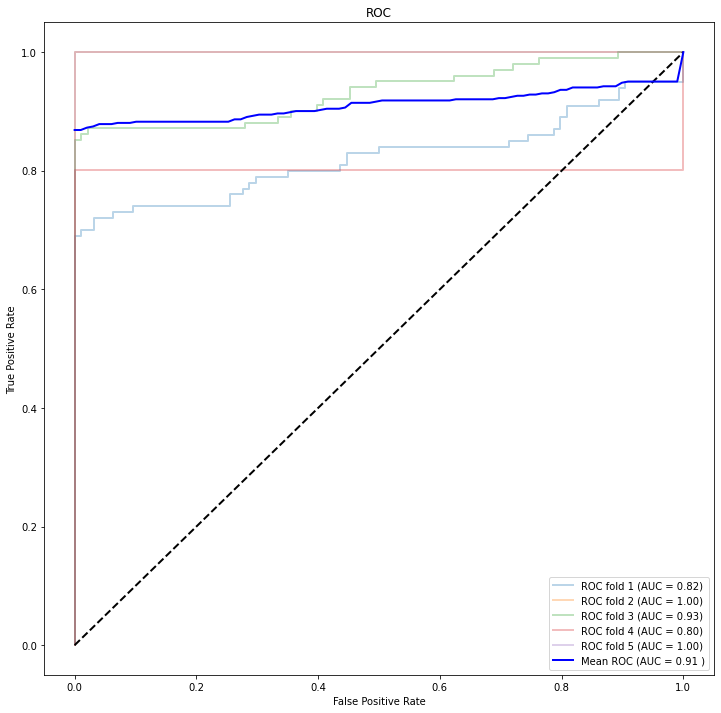

In [54]:
model = SVC(kernel='rbf', gamma='auto', C=100, class_weight='balanced', tol=1e-5, probability=True)
strtfdKFold = StratifiedKFold(n_splits=5, shuffle=False)

cms = []
bas = []
prfs = []

tprs = []
aucs = []

index = 1
mean_fpr = np.linspace(0, 1, 100)

fig1 = plt.figure(figsize=[12, 12])

for train, test in tqdm(strtfdKFold.split(X_train, Y_train),
                        total=strtfdKFold.get_n_splits(),
                        desc="k-fold"):
  # make fit on train data
  model.fit(X_train[train],Y_train[train])
  # predict on test data
  y_pred = model.predict(X_train[test])
  prediction = model.predict_proba(X_train[test])
  # calculate balanced accuracy for fold
  bas.append(balanced_accuracy_score(Y_train[test], y_pred))
  # calculate precision, recall, fscore, support for fold
  prfs.append(precision_recall_fscore_support(Y_train[test], y_pred, average=None))
  # calculate confusion matrix for fold
  cm = confusion_matrix(Y_train[test], y_pred)
  cms.append(ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.inverse_transform(np.unique(Y_train))))
  # calculate roc curve
  fpr, tpr, t = roc_curve(Y_train[test], prediction[:, 1])
  tprs.append(np.interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  # insert auc in plot
  plt.plot(fpr,
           tpr,
           lw=2,
           alpha=0.3,
           label='ROC fold %d (AUC = %0.2f)' % (index, roc_auc))
  index += 1

# insert mean roc curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
# insert plot of mean roc curve
plt.plot(mean_fpr,
         mean_tpr,
         color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),
         lw=2,
         alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [55]:
print("Mean balanced accuracy: ", np.mean(bas))
print("Mean precision: ", np.mean(prfs, axis=0)[0])
print("Mean recall: ", np.mean(prfs, axis=0)[1])
print("Mean fscore: ", np.mean(prfs, axis=0)[2])

Mean balanced accuracy:  0.9273762376237624
Mean precision:  [0.87790577 1.        ]
Mean recall:  [1.         0.85475248]
Mean fscore:  [0.93154533 0.91603252]


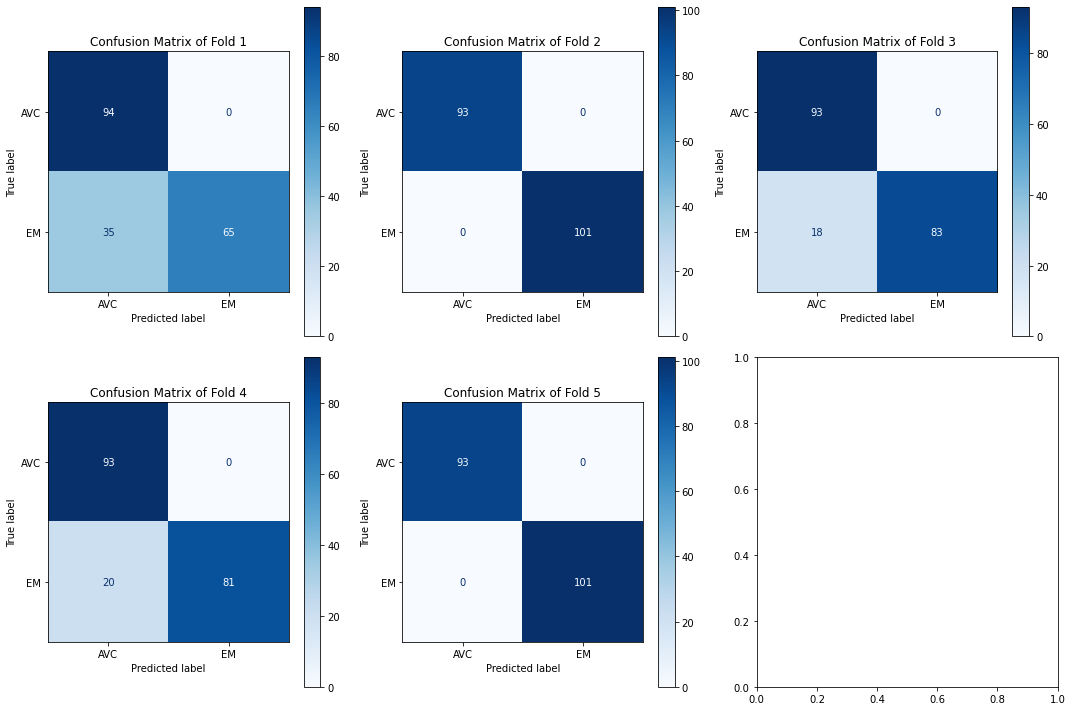

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

index = 1
for disp, ax in zip(cms, axes.flat):
  if index <= 5:
    disp.plot(ax=ax, cmap=plt.get_cmap('Blues'))
    ax.set_title(f'Confusion Matrix of Fold {index}')
  index += 1

plt.tight_layout()
plt.show()

In [57]:
y_pred = model.predict(X_val)
print(classification_report(Y_val, y_pred, digits=4, target_names=le.inverse_transform(range(len(le.classes_)))))

              precision    recall  f1-score   support

         AVC     0.8582    1.0000    0.9237       115
          EM     1.0000    0.8480    0.9177       125

    accuracy                         0.9208       240
   macro avg     0.9291    0.9240    0.9207       240
weighted avg     0.9321    0.9208    0.9206       240



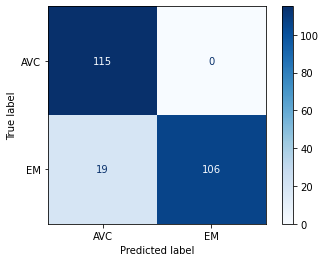

In [58]:
cm = confusion_matrix(Y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.inverse_transform(np.unique(Y_val)))
disp.plot(cmap=plt.get_cmap('Blues'))